In [1]:
from possession import *
from sklearn.externals import joblib
import numpy as np
import pandas as pd
import glob
import tqdm
from collections import Counter
import seaborn as sns
from legacy.code_mapping import gid2name, code2team

In [4]:
p = joblib.load('../new_traj_data/2017012001/Possession(2017012001, 1v4, 603.5-558.9, q2, Field Goal Missed, p0).pkl')

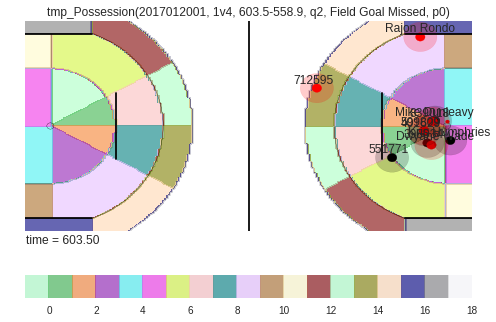

In [123]:
p.animate()
plt.show()

<video controls src="tmp_Possession(2017012001, 1v4, 603.5-558.9, q2, Field Goal Missed, p0).mp4" />

# Q1 Dataset Statistics

The dataset contains 2014-2017 (3 seasons data) with 3923 games in total (87 games per team on average, 2013-2014 data excluded because doesn't contain shot information). 

**a) what's the end event distribution?**

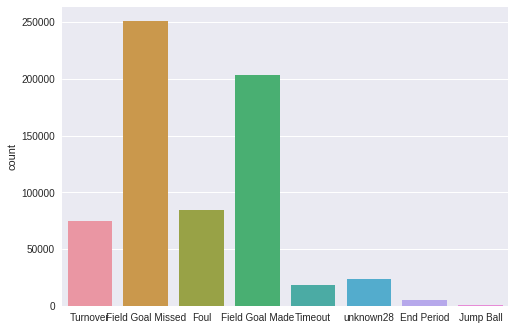

In [37]:
end_events = joblib.load('result/end_event_dist.pkl')
sns.countplot(end_events)
plt.show()

From raw data, we can find that event code 11 means "Timeout", event code 15 means "End Period", event code 12 means "Jump Ball". I will exclude "Jump Ball" in the next iteration of generating the data.

**b) what's trajectory length distribution?**

The way a possession is extracted can be imprecise (possession start when hit event "possession", possession end when hit any of the end of possession event).

Reasons for running over 24s: 

a) the shot goes out of hand before 24 second mark, but the event of shot made is after

b) unknown event id of 28 encountered, not sure what this event is, it is in the event csv file, but this event is not documented anywhere. There seems to be some inconsistency in the way the raw data keeping track of event id (the raw play by play data have event 3 while raw event data have event 28); From the dataset, I checked that event 28 is the only event we missed. The proper way to handle this seems to be either start preprocessing from play by play data (this means restrucutre the possession extraction code) or stop possession whenever a foreign event code is met. The latter plan seems more feasible. 

c) The play by play data can actually go over 24 second if the ball is interrupted but didn't change possession (see 2017020607, 7v6, 424.3-392.5, q4, Field Goal Missed, p0). We want continuous play, so ignore the pbp_squence_num would be the choice.

d) The data doesn't mark the end of event (e.g., Possession(2017012001, 1v4, 603.5-558.9, q2, Field Goal Missed, p0).pkl)

In [46]:
traj_lengths = joblib.load('result/traj_length_dist.pkl')

In [48]:
gt24 = np.array(traj_lengths) > 24
le0 = np.array(traj_lengths) <= 0
sum(gt24), sum(le0), len(traj_lengths)

(8684, 5351, 704684)

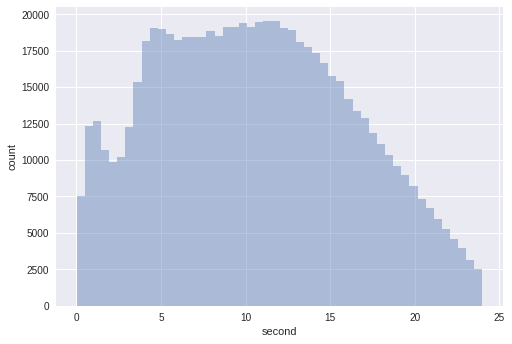

In [202]:
sns.distplot(np.array(traj_lengths)[np.logical_and(~gt24, ~le0)], kde=False)
plt.xlabel('second')
plt.ylabel('count')
plt.show()

# Q2 Players with most data

**a) player frames count**

In [203]:
player_frames_count = joblib.load('result/player_frames_count.pkl')
list(map(lambda x: (gid2name(x[0]), x[1]), sorted(player_frames_count.items(), key=lambda x: x[1], reverse=True)[:10]))

[('James Harden', 13323437),
 ('LeBron James', 12816624),
 ('Trevor Ariza', 12632460),
 ('Stephen Curry', 12453463),
 ('468895', 12366762),
 ('Klay Thompson', 12290432),
 ('John Wall', 11658169),
 ('463121', 11417470),
 ('794503', 11366185),
 ('DeAndre Jordan', 11235007)]

**b) player possessions count**

In [204]:
player_poss_count = joblib.load('result/player_poss_count.pkl')
list(map(lambda x: (gid2name(x[0]), x[1]), sorted(player_poss_count.items(), key=lambda x: x[1], reverse=True)[:10]))

[('James Harden', 46317),
 ('Stephen Curry', 44079),
 ('Trevor Ariza', 43891),
 ('468895', 43427),
 ('Klay Thompson', 43095),
 ('LeBron James', 42937),
 ('John Wall', 40017),
 ('463121', 38625),
 ('794503', 38449),
 ('Russell Westbrook', 38260)]

# Q3 most physical teams

In [23]:
# use tmp.py to extract
team_defense_closeness = joblib.load('result/old_team_defense_closeness.pkl')

**a) overall physicality **

In [205]:
def physicality(team_defense_closeness, criteria=lambda x: True):
    result = []
    for k, v in team_defense_closeness.items():
        if code2team.get(k, None) is None: continue
        result.append((code2team[k], np.mean([dist for dist, frameInfo in v if criteria(frameInfo)])))
    return result

def print_physicality(result, to_sort=True):
    if to_sort:
        result = sorted(result, key=lambda x: x[1]) 
    for k, v in result:
        print("%20s\t%.3f" % (k, v))
        
res = physicality(team_defense_closeness)
print_physicality(res)

          Washington	9.278
             Houston	9.295
           Minnesota	9.315
             Chicago	9.366
                Utah	9.378
             Orlando	9.378
             Phoenix	9.405
Los Angeles Clippers	9.460
         San Antonio	9.471
             Memphis	9.477
              Boston	9.483
        Philadelphia	9.508
          Sacramento	9.509
           Cleveland	9.518
            New York	9.521
  Los Angeles Lakers	9.548
          New Jersey	9.570
              Dallas	9.639
        Golden State	9.679
         New Orleans	9.712
             Atlanta	9.719
           Milwaukee	9.764
             Indiana	9.783
              Denver	9.816
            Portland	9.829
               Miami	9.829
       Oklahoma City	9.928
             Detroit	9.939
             Toronto	9.957
           Charlotte	10.298


**b) by quarter physicality**

In [164]:
print('\nQuater1')
resQ1 = physicality(team_defense_closeness, criteria=lambda frameInfo: frameInfo.quarter==1)
print_physicality(resQ1, to_sort=False)

print('\nQuater2')
resQ2 = physicality(team_defense_closeness, criteria=lambda frameInfo: frameInfo.quarter==2)
print_physicality(resQ2, to_sort=False)

print('\nQuater3')
resQ3 = physicality(team_defense_closeness, criteria=lambda frameInfo: frameInfo.quarter==3)
print_physicality(resQ3, to_sort=False)

print('\nQuater4')
resQ4 = physicality(team_defense_closeness, criteria=lambda frameInfo: frameInfo.quarter==4)
print_physicality(resQ4, to_sort=False)



Quater1
           Charlotte	10.327
             Atlanta	9.790
              Boston	9.531
         New Orleans	9.762
             Chicago	9.442
           Cleveland	9.524
              Dallas	9.666
              Denver	9.900
             Detroit	9.928
        Golden State	9.696
             Houston	9.319
             Indiana	9.840
Los Angeles Clippers	9.670
  Los Angeles Lakers	9.685
               Miami	9.846
           Milwaukee	9.751
           Minnesota	9.345
          New Jersey	9.666
            New York	9.720
             Orlando	9.285
        Philadelphia	9.594
             Phoenix	9.423
            Portland	9.870
          Sacramento	9.615
         San Antonio	9.516
       Oklahoma City	9.886
                Utah	9.483
          Washington	9.295
             Toronto	10.061
             Memphis	9.509

Quater2
           Charlotte	10.212
             Atlanta	9.737
              Boston	9.562
         New Orleans	9.604
             Chicago	9.308
           Cleveland	9.447
       

In [165]:
def physicality_diff(res1, res2):
    print_physicality([(n1, score1 - score2) for (n1, score1), (n2, score2) in zip(res1, res2) if n1 == n2])
    
print('*difference between 4th quarter defense closeness and overall defense closeness*')
physicality_diff(resQ4, res)

*difference between 4th quarter defense closeness and overall defense closeness*
Los Angeles Clippers	-0.288
            New York	-0.257
             Chicago	-0.218
          Sacramento	-0.204
  Los Angeles Lakers	-0.200
              Boston	-0.199
          New Jersey	-0.193
             Indiana	-0.189
              Denver	-0.185
         New Orleans	-0.159
             Atlanta	-0.158
             Toronto	-0.152
                Utah	-0.150
           Minnesota	-0.150
            Portland	-0.150
        Philadelphia	-0.135
         San Antonio	-0.131
           Charlotte	-0.118
             Memphis	-0.112
               Miami	-0.108
          Washington	-0.104
             Houston	-0.101
              Dallas	-0.098
        Golden State	-0.095
             Phoenix	-0.079
           Cleveland	-0.076
       Oklahoma City	-0.062
             Detroit	-0.058
           Milwaukee	-0.005
             Orlando	0.004


In [166]:
res_max_quarters = [(n1, np.argmin([s1, s2, s3, s4]) + 1) for (n1, s1), (n2, s2), (n3, s3), (n4, s4) 
                    in zip(resQ1, resQ2, resQ3, resQ4) 
                    if n1 == n2 == n3 == n4]
print('*which quarter has the smallest defensive gap?*')
print_physicality(res_max_quarters)

*which quarter has the smallest defensive gap?*
             Orlando	1.000
           Milwaukee	2.000
          Washington	2.000
           Charlotte	4.000
             Atlanta	4.000
              Boston	4.000
         New Orleans	4.000
             Chicago	4.000
           Cleveland	4.000
              Dallas	4.000
              Denver	4.000
             Detroit	4.000
        Golden State	4.000
             Houston	4.000
             Indiana	4.000
Los Angeles Clippers	4.000
  Los Angeles Lakers	4.000
               Miami	4.000
           Minnesota	4.000
          New Jersey	4.000
            New York	4.000
        Philadelphia	4.000
             Phoenix	4.000
            Portland	4.000
          Sacramento	4.000
         San Antonio	4.000
       Oklahoma City	4.000
                Utah	4.000
             Toronto	4.000
             Memphis	4.000


**c) is playoff more physical?**

In [217]:
# a little lazy, just use 4/13 and 7/01 as a cutoff date
def isPlayOff(frameInfo):
    date = int(str(frameInfo.gamecode)[4:8])
    return 413 < date < 701
    
resPlayoff = physicality(team_defense_closeness, criteria=isPlayOff)
physicality_diff(resPlayoff, res)
#print_physicality(resPlayoff)

               Miami	-0.566
              Denver	-0.549
             Memphis	-0.350
         New Orleans	-0.256
            Portland	-0.254
       Oklahoma City	-0.224
Los Angeles Clippers	-0.222
           Milwaukee	-0.194
             Toronto	-0.142
             Houston	-0.114
           Cleveland	-0.095
             Orlando	-0.019
        Golden State	-0.010
         San Antonio	0.036
             Indiana	0.036
           Minnesota	0.052
          Washington	0.074
                Utah	0.077
           Charlotte	0.079
              Dallas	0.135
            New York	0.209
          New Jersey	0.212
             Atlanta	0.216
  Los Angeles Lakers	0.248
          Sacramento	0.309
             Chicago	0.317
              Boston	0.347
        Philadelphia	0.372
             Detroit	0.497
             Phoenix	0.816


**d) per year ranking**

In [218]:
def isSeason(year):
    # by season
    def ret(frameInfo):
        y = int(str(frameInfo.gamecode)[:4])
        month = int(str(frameInfo.gamecode)[4:6])
        return (y == year and month > 8) or (y == year+1 and month < 8)
    return ret
    
resPerYear = physicality(team_defense_closeness, criteria=isSeason(2014))
print_physicality(resPerYear)

             Houston	8.926
          Washington	9.113
              Dallas	9.158
                Utah	9.176
             Chicago	9.185
             Memphis	9.239
         San Antonio	9.294
             Orlando	9.358
  Los Angeles Lakers	9.367
              Boston	9.368
          Sacramento	9.370
              Denver	9.411
           Minnesota	9.440
        Philadelphia	9.442
            New York	9.449
           Cleveland	9.483
Los Angeles Clippers	9.526
             Indiana	9.536
        Golden State	9.551
             Detroit	9.628
            Portland	9.631
          New Jersey	9.651
             Phoenix	9.651
           Milwaukee	9.665
         New Orleans	9.712
               Miami	9.733
             Atlanta	9.787
             Toronto	9.902
       Oklahoma City	9.958
           Charlotte	10.023


In [219]:
resPerYear = physicality(team_defense_closeness, criteria=isSeason(2015))
print_physicality(resPerYear)

           Minnesota	9.070
             Orlando	9.106
             Houston	9.137
          Washington	9.305
        Philadelphia	9.337
                Utah	9.403
          New Jersey	9.420
             Chicago	9.437
Los Angeles Clippers	9.440
           Cleveland	9.452
  Los Angeles Lakers	9.496
             Phoenix	9.499
            New York	9.505
             Memphis	9.512
              Boston	9.525
         San Antonio	9.568
             Atlanta	9.608
          Sacramento	9.625
         New Orleans	9.737
        Golden State	9.758
           Milwaukee	9.758
               Miami	9.805
            Portland	9.873
             Indiana	9.876
             Detroit	9.952
              Dallas	9.981
       Oklahoma City	10.036
              Denver	10.075
             Toronto	10.099
           Charlotte	10.466


In [220]:
resPerYear = physicality(team_defense_closeness, criteria=isSeason(2016))
print_physicality(resPerYear)

             Phoenix	9.058
Los Angeles Clippers	9.408
          Washington	9.415
           Minnesota	9.442
             Chicago	9.491
          Sacramento	9.530
                Utah	9.532
         San Antonio	9.545
              Boston	9.547
            New York	9.605
           Cleveland	9.619
          New Jersey	9.633
             Orlando	9.669
         New Orleans	9.687
             Memphis	9.696
        Golden State	9.733
        Philadelphia	9.740
             Atlanta	9.760
  Los Angeles Lakers	9.776
       Oklahoma City	9.781
              Dallas	9.810
             Houston	9.824
             Toronto	9.858
           Milwaukee	9.872
             Indiana	9.912
               Miami	9.955
              Denver	9.979
            Portland	9.979
             Detroit	10.232
           Charlotte	10.389


**e) only focus on half court**

In [174]:
resHalfCourt = physicality(team_defense_closeness, criteria=lambda frameInfo: not frameInfo.transition)
print_physicality(resHalfCourt)

Los Angeles Clippers	7.040
          Washington	7.081
           Minnesota	7.121
         San Antonio	7.121
             Chicago	7.144
           Cleveland	7.147
                Utah	7.155
              Boston	7.159
             Phoenix	7.165
        Golden State	7.216
            Portland	7.231
         New Orleans	7.240
             Detroit	7.240
       Oklahoma City	7.259
        Philadelphia	7.268
             Memphis	7.272
  Los Angeles Lakers	7.287
             Orlando	7.300
             Indiana	7.321
             Houston	7.336
               Miami	7.339
          New Jersey	7.345
            New York	7.346
             Atlanta	7.453
           Charlotte	7.456
              Denver	7.459
              Dallas	7.464
          Sacramento	7.514
             Toronto	7.531
           Milwaukee	7.631


In [175]:
resPlayoffHalfCourt = physicality(team_defense_closeness, criteria=lambda x: isPlayOff(x) and (not x.transition))
physicality_diff(resPlayoffHalfCourt, resHalfCourt)

            Portland	-0.422
         New Orleans	-0.382
       Oklahoma City	-0.319
             Memphis	-0.225
               Miami	-0.183
           Cleveland	-0.182
          Sacramento	-0.166
             Houston	-0.088
            New York	-0.047
        Golden State	-0.023
                Utah	-0.008
             Toronto	0.014
          Washington	0.033
Los Angeles Clippers	0.060
  Los Angeles Lakers	0.068
             Indiana	0.123
         San Antonio	0.150
             Orlando	0.162
              Denver	0.170
           Charlotte	0.183
           Milwaukee	0.183
             Atlanta	0.188
              Dallas	0.199
              Boston	0.244
          New Jersey	0.272
        Philadelphia	0.277
             Detroit	0.358
             Chicago	0.361
           Minnesota	0.440
             Phoenix	0.604


In [206]:
resQ4HalfCourt = physicality(team_defense_closeness, criteria=lambda x: (x.quarter==4) and (not x.transition))
physicality_diff(resQ4HalfCourt, resHalfCourt)

            Portland	-0.079
             Chicago	-0.075
  Los Angeles Lakers	-0.069
              Denver	-0.067
          New Jersey	-0.066
           Minnesota	-0.056
             Indiana	-0.055
Los Angeles Clippers	-0.052
              Dallas	-0.046
               Miami	-0.045
         New Orleans	-0.043
        Golden State	-0.042
            New York	-0.039
                Utah	-0.039
          Sacramento	-0.033
             Atlanta	-0.033
             Houston	-0.024
        Philadelphia	-0.023
             Detroit	-0.023
             Toronto	-0.023
       Oklahoma City	-0.021
              Boston	-0.014
           Cleveland	-0.009
             Memphis	0.001
           Charlotte	0.006
             Phoenix	0.015
         San Antonio	0.020
          Washington	0.023
           Milwaukee	0.024
             Orlando	0.035


**f) is defensive closeness correlated to score difference? **

In [11]:
boxscores = joblib.load('data/boxscore.pkl')

In [28]:
def scorediff_closeness(team_defense_closeness, criteria=lambda frameInfo: True):
    x = []
    y = []
    for k, v in tqdm.tqdm(team_defense_closeness.items()):
        for closeness, frameInfo in v:
            if not criteria(frameInfo):
                continue
                
            y.append(closeness)
            b = boxscores[str(frameInfo.gamecode)]

            i = 1
            if str(k) == b[0][1]: # determine who is defending
                i = 0
            x.append(sum(b[i][2][:frameInfo.quarter]) - sum(b[1-i][2][:frameInfo.quarter]))
    return np.array(x), np.array(y)

#x, y = scorediff_closeness(team_defense_closeness, criteria=lambda frameInfo: not frameInfo.transition)
#x, y = scorediff_closeness(team_defense_closeness, criteria=lambda frameInfo: frameInfo.transition)
x, y = scorediff_closeness(team_defense_closeness)

100%|██████████| 32/32 [00:21<00:00,  1.51it/s]


In [210]:
def getA(x, degree=3):
    return np.vstack([x**d for d in range(degree+1)]).T

A = getA(x)
theta, residues = np.linalg.lstsq(A, y)[:2]
residues

array([  1.32390305e+08])

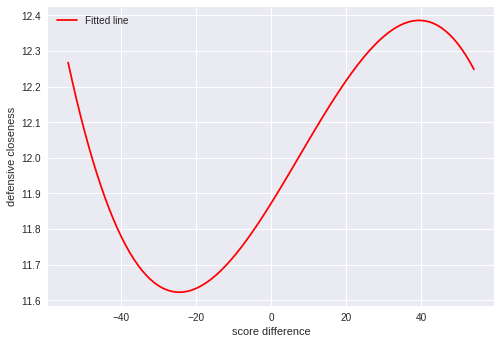

In [211]:
xrange = np.linspace(x.min(), x.max(), 100)
plt.plot(xrange, getA(xrange).dot(theta), 'r', label='Fitted line')
plt.legend()
plt.ylabel('defensive closeness')
plt.xlabel('score difference')
plt.show()

In [43]:
sns.set_style("whitegrid")

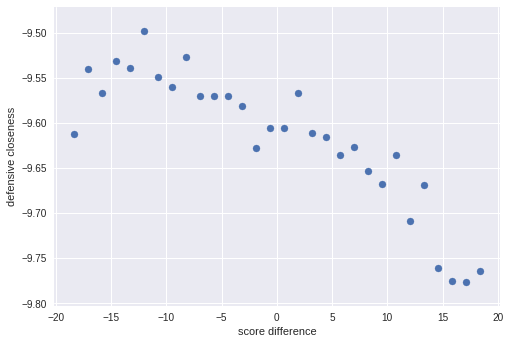

showing mean and std


In [38]:
# look at how the empirical distribution looks like by looking at bins
def transform_closeness(y):
    return -y

nbins = 30
l, r = np.percentile(x, [5, 95])
bins = np.linspace(l, r, nbins+1)

x_avg = []
y_avg = []
y_std = []
for i in range(nbins):
    indices = np.logical_and(bins[i] < x, x < bins[i+1])
    x_avg.append(np.mean([bins[i], bins[i+1]]))
    y_avg.append(transform_closeness(y)[indices].mean())
    y_std.append(transform_closeness(y)[indices].std())
    
    
x_avg = np.array(x_avg)
y_avg = np.array(y_avg)
y_std = np.array(y_std)

nstd = 0.01
plt.scatter(x_avg, y_avg)
#plt.fill_between(x_avg, y_avg + nstd * y_std, y_avg - nstd * y_std, facecolor='blue', alpha=0.2)
plt.ylabel('defensive closeness')
plt.xlabel('score difference')
plt.show()

print('showing mean and std')

#sns.distplot(x)
#plt.title('score difference distribtuion')
#plt.show()

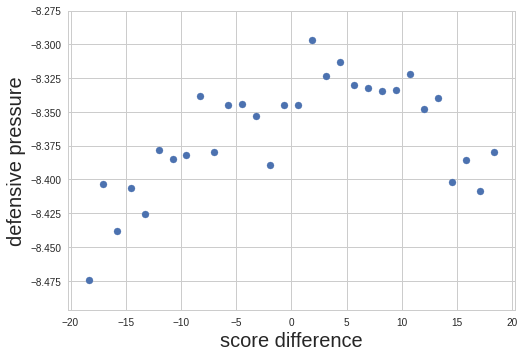

showing median and iqr


In [44]:
# look at how the empirical distribution looks like by looking at bins
nbins = 30
l, r = np.percentile(x, [5, 95])
bins = np.linspace(l, r, nbins+1)

x_avg = []
y_med = []
y_q1 = []
y_q3 = []

for i in range(nbins):
    indices = np.logical_and(bins[i] < x, x < bins[i+1])
    x_avg.append(np.mean([bins[i], bins[i+1]]))
    y_med.append(transform_closeness(np.percentile(y[indices], 50)))
    y_q1.append(transform_closeness(np.percentile(y[indices], 25)))
    y_q3.append(transform_closeness(np.percentile(y[indices], 75)))
    
x_avg = np.array(x_avg)
y_med = np.array(y_med)
y_q1 = np.array(y_q1)
y_q3 = np.array(y_q3)

nstd = 0.01
plt.scatter(x_avg, y_med)
#plt.fill_between(x_avg, y_q3, y_q1, facecolor='blue', alpha=0.2)
plt.ylabel('defensive pressure', fontsize=20)
plt.xlabel('score difference', fontsize=20)
plt.savefig('defense_pressure.png')
plt.show()


print('showing median and iqr')


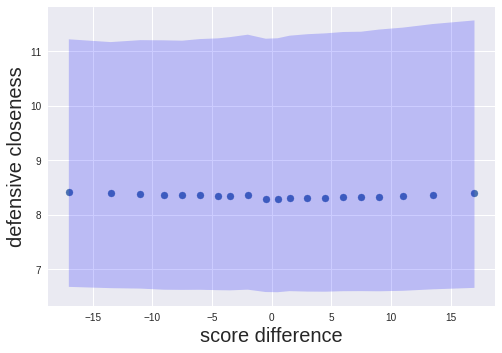

showing median and iqr


In [32]:
# look at how the empirical distribution looks like by looking at bins
nbins = 20
bins = [np.percentile(x, i) for i in np.linspace(5, 95, nbins+1)]

x_avg = []
y_med = []
y_q1 = []
y_q3 = []

for i in range(nbins):
    indices = np.logical_and(bins[i] <= x, x <= bins[i+1])
    x_avg.append(np.mean([bins[i], bins[i+1]]))
    y_med.append(np.percentile(transform_closeness(y)[indices], 50))
    y_q1.append(np.percentile(transform_closeness(y)[indices], 25))
    y_q3.append(np.percentile(transform_closeness(y)[indices], 75))
    
x_avg = np.array(x_avg)
y_med = np.array(y_med)
y_q1 = np.array(y_q1)
y_q3 = np.array(y_q3)

plt.scatter(x_avg, y_med)
plt.fill_between(x_avg, y_q3, y_q1, facecolor='blue', alpha=0.2)
plt.ylabel('defensive closeness', fontsize=20)
plt.xlabel('score difference', fontsize=20)
plt.show()

print('showing median and iqr')


In [279]:
from main import poss_defense_closeness
poss_defense_closeness(p)

([10.260169460327528,
  11.637396589644899,
  7.3006737132375905,
  6.3413254149454028,
  12.533899243685605],
 [True, False, False, False, False])

# Q4 Trajectory MNIST